## 5.1 銷售成交預測（分類）


### 共通事前處理

In [ ]:
# 取得中文字型
!wget 'https://github.com/flyingpath/electron-hand-dicom/raw/master/TaipeiSansTCBeta-Regular.ttf'

--2021-11-26 07:23:04--  https://github.com/flyingpath/electron-hand-dicom/raw/master/TaipeiSansTCBeta-Regular.ttf
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/flyingpath/electron-hand-dicom/master/TaipeiSansTCBeta-Regular.ttf [following]
--2021-11-26 07:23:05--  https://raw.githubusercontent.com/flyingpath/electron-hand-dicom/master/TaipeiSansTCBeta-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf.1’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  99.7MB/s    in 0.2s    

2021-11-26 07:23:0

In [ ]:
# 共通事前處理

# 隱藏不必要的警告
import warnings
warnings.filterwarnings('ignore')

# 匯入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 將字型新增到 matplotlib
fm.fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')

# 用來顯示資料框的函式
from IPython.display import display

# 調整顯示選項
# NumPy 的浮點數表示精度
np.set_printoptions(suppress=True, precision=4)
# pandas 中的浮點數表示精度
pd.options.display.float_format = '{:.4f}'.format
# 顯示資料框中的所有項目
pd.set_option("display.max_columns",None)
# 指定圖形的預設字體大小
plt.rcParams["font.size"] = 14
# 指定圖形的預設字型
plt.rcParams['font.family'] = 'Taipei Sans TC Beta'
# 隨機種子
random_seed = 123

In [ ]:
# 用於顯示混淆矩陣之函式

def make_cm(matrix, columns):
    # matrix numpy 陣列
    
    # columns 項目名稱列表
    n = len(columns)
    
    # 將 '標準答案' 重複 n 次以生成列表
    act = ['標準答案'] * n
    pred = ['預測結果'] * n
    
    # 生成資料框
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

### 5.1.4 從載入資料到確認資料

#### 載入資料

In [ ]:
# 下載並解壓縮公開資料集
!wget https://archive.ics.uci.edu/ml/\
machine-learning-databases/00222/bank.zip
!unzip -o bank.zip

# 將 bank-full.csv 載入資料框中
df_all = pd.read_csv('bank-full.csv', sep=';')

# 將項目名稱替換成中文
columns = [
    '年齡', '職業', '婚姻', '學歷', '違約', '平均餘額',
    '房屋貸款', '個人信貸', '聯絡方式', '最近一次通話日期',
    '最近一次通話月份', '最近一次通話秒數', '通話次數_促銷期間',
    '上次促銷後_經過天數', '通話次數_促銷之前', '上次促銷結果',
    '本次促銷結果'
]
df_all.columns = columns

--2021-11-26 07:23:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip.1’

bank.zip.1          100%[===================>] 565.47K   872KB/s    in 0.6s    

2021-11-26 07:23:08 (872 KB/s) - ‘bank.zip.1’ saved [579043/579043]

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


#### 確認資料

In [ ]:
# 確認資料框的內容
display(df_all.head())

,年齡,職業,婚姻,學歷,違約,平均餘額,房屋貸款,個人信貸,聯絡方式,最近一次通話日期,最近一次通話月份,最近一次通話秒數,通話次數_促銷期間,上次促銷後_經過天數,通話次數_促銷之前,上次促銷結果,本次促銷結果
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# 確認訓練資料的筆數與項目數
print(df_all.shape)
print()

# 確認「本次促銷結果」的分佈
print(df_all['本次促銷結果'].value_counts())
print()

# 銷售成功率
rate = df_all['本次促銷結果'].value_counts()['yes']/len(df_all)
print(f'銷售成功率 : {rate:.4f}')

(45211, 17)

no     39922
yes     5289
Name: 本次促銷結果, dtype: int64

銷售成功率 : 0.1170


In [ ]:
# 確認缺失值
print(df_all.isnull().sum())

年齡            0
職業            0
婚姻            0
學歷            0
違約            0
平均餘額          0
房屋貸款          0
個人信貸          0
聯絡方式          0
最近一次通話日期      0
最近一次通話月份      0
最近一次通話秒數      0
通話次數_促銷期間     0
上次促銷後_經過天數    0
通話次數_促銷之前     0
上次促銷結果        0
本次促銷結果        0
dtype: int64


### 5.1.5 預處理資料與分割資料

#### 預處理資料

##### 預處理 step 1

In [ ]:
# 利用 get_dummies 函式對種類值進行 One-Hot 編碼

# 用於對項目進行 One-Hot 編碼之函式
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop([column],axis=1),df_dummy],axis=1)
    return df

df_all2 = df_all.copy()
df_all2 = enc(df_all2, '職業')
df_all2 = enc(df_all2, '婚姻')
df_all2 = enc(df_all2, '學歷')
df_all2 = enc(df_all2, '聯絡方式')
df_all2 = enc(df_all2, '上次促銷結果')

# 確認結果
display(df_all2.head())

,年齡,違約,平均餘額,房屋貸款,個人信貸,最近一次通話日期,最近一次通話月份,最近一次通話秒數,通話次數_促銷期間,上次促銷後_經過天數,通話次數_促銷之前,本次促銷結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,學歷_primary,學歷_secondary,學歷_tertiary,學歷_unknown,聯絡方式_cellular,聯絡方式_telephone,聯絡方式_unknown,上次促銷結果_failure,上次促銷結果_other,上次促銷結果_success,上次促銷結果_unknown
0,58,no,2143,yes,no,5,may,261,1,-1,0,no,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,no,29,yes,no,5,may,151,1,-1,0,no,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,no,2,yes,yes,5,may,76,1,-1,0,no,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,no,1506,yes,no,5,may,92,1,-1,0,no,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,no,1,no,no,5,may,198,1,-1,0,no,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


##### 預處理 step2

In [ ]:
# 以 1/0 替換 yes/no

# 用於將二元（yes/no）之值替換成（1/0）的函式
def enc_bin(df, column):
    df[column] = df[column].map(dict(yes=1, no=0)) 
    return df

df_all2 = enc_bin(df_all2, '違約')
df_all2 = enc_bin(df_all2, '房屋貸款')
df_all2 = enc_bin(df_all2, '個人信貸')
df_all2 = enc_bin(df_all2, '本次促銷結果')

# 確認結果
display(df_all2.head())

,年齡,違約,平均餘額,房屋貸款,個人信貸,最近一次通話日期,最近一次通話月份,最近一次通話秒數,通話次數_促銷期間,上次促銷後_經過天數,通話次數_促銷之前,本次促銷結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,學歷_primary,學歷_secondary,學歷_tertiary,學歷_unknown,聯絡方式_cellular,聯絡方式_telephone,聯絡方式_unknown,上次促銷結果_failure,上次促銷結果_other,上次促銷結果_success,上次促銷結果_unknown
0,58,0,2143,1,0,5,may,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,may,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,may,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,may,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,may,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


##### 預處理 step3

In [ ]:
# 將月份名稱 (jan, feb, ...) 替換成 1,2, ...

month_dict = dict(jan=1, feb=2, mar=3, apr=4, 
    may=5, jun=6, jul=7, aug=8, sep=9, oct=10, 
    nov=11, dec=12)

def enc_month(df, column):
    df[column] = df[column].map(month_dict)
    return df

df_all2 = enc_month(df_all2, '最近一次通話月份')

# 確認結果
display(df_all2.head())

,年齡,違約,平均餘額,房屋貸款,個人信貸,最近一次通話日期,最近一次通話月份,最近一次通話秒數,通話次數_促銷期間,上次促銷後_經過天數,通話次數_促銷之前,本次促銷結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,學歷_primary,學歷_secondary,學歷_tertiary,學歷_unknown,聯絡方式_cellular,聯絡方式_telephone,聯絡方式_unknown,上次促銷結果_failure,上次促銷結果_other,上次促銷結果_success,上次促銷結果_unknown
0,58,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


#### 分割資料

In [ ]:
# 分割輸入資料與標準答案
x = df_all2.drop('本次促銷結果', axis=1)
y = df_all2['本次促銷結果'].values

# 分割訓練資料與驗證資料
# 以訓練資料 60%、驗證資料 40% 的比例分割
test_size = 0.4

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=test_size, random_state=random_seed,
  stratify=y)

### 5.1.6 選擇演算法

#### 選擇演算法

In [ ]:
# 將候選演算法建立成列表

# 邏輯斯迴歸（4.3.3）
from sklearn.linear_model import LogisticRegression
algorithm1 = LogisticRegression(random_state=random_seed)

# 決策樹（4.3.6）
from sklearn.tree import DecisionTreeClassifier
algorithm2 = DecisionTreeClassifier(random_state=random_seed)

# 隨機森林（4.3.7）
from sklearn.ensemble import RandomForestClassifier
algorithm3 = RandomForestClassifier(random_state=random_seed)

# XGBoost（4.3.8）
from xgboost import XGBClassifier
algorithm4 = XGBClassifier(random_state=random_seed)


algorithms = [algorithm1, algorithm2, algorithm3, algorithm4]

In [ ]:
# 利用交叉驗證選擇最佳演算法
from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import cross_val_score
for algorithm in algorithms:
    # 進行交叉驗證
    scores = cross_val_score(algorithm , x_train, y_train,
        cv=stratifiedkfold, scoring='roc_auc')
    score = scores.mean()
    name = algorithm.__class__.__name__
    print(f'平均分數 :  {score:.4f}  個別分數 : {scores}  {name}')

平均分數 :  0.8325  個別分數 : [0.8275 0.8287 0.8412]  LogisticRegression
平均分數 :  0.6958  個別分數 : [0.6917 0.7023 0.6935]  DecisionTreeClassifier
平均分數 :  0.9200  個別分數 : [0.9259 0.9196 0.9145]  RandomForestClassifier
平均分數 :  0.9222  個別分數 : [0.9246 0.9213 0.9206]  XGBClassifier


#### 結論
XGBboost　是 4 個候選演算法中 AUC 最高的  
-> 接下來的步驟使用 XGBoost

### 5.1.7 訓練、預測、評估

In [ ]:
# 選擇演算法
# 使用 XGBoost
algorithm = XGBClassifier(random_state=random_seed)

# 訓練
algorithm.fit(x_train, y_train)

# 預測
y_pred = algorithm.predict(x_test)

In [ ]:
# 評估

# 輸出混淆矩陣
from sklearn.metrics import confusion_matrix
df_matrix = make_cm(
    confusion_matrix(y_test, y_pred), ['失敗', '成功'])
display(df_matrix)

# 計算精準率、召回率及 F 分數
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary')
print(f'精確性 : {precision:.4f}  召回率 : {recall:.4f}  F 分數 : {fscore:.4f}')

預測結果     
            失敗   成功
標準答案 失敗  15593  376
     成功   1341  775

精確性 : 0.6733  召回率 : 0.3663  F 分數 : 0.4744


### 5.1.8 調整

#### 率值的次數分佈圖

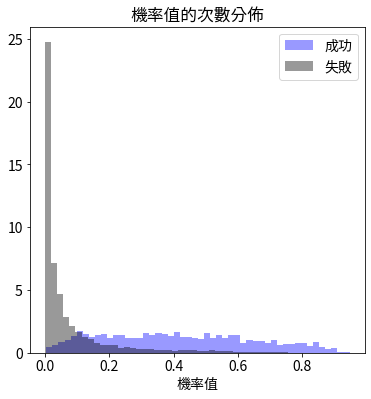

In [ ]:
# 機率值的次數分佈圖
import seaborn as sns

# 取得 y=1 的機率值
y_proba1 = algorithm.predict_proba(x_test)[:,1]

# 將資料依 y_test=0 與 y_test=1 進行分割
y0 = y_proba1[y_test==0]
y1 = y_proba1[y_test==1]

# 繪製散佈圖
plt.figure(figsize=(6,6))
plt.title('機率值的次數分佈')
sns.distplot(y1, kde=False, norm_hist=True,
    bins=50, color='b', label='成功')
sns.distplot(y0, kde=False, norm_hist=True,
    bins=50, color='k', label='失敗')
plt.xlabel('機率值')
plt.legend()
plt.show()

#### 利用 predict_proba 函式預測閾值為 0.5 以外時的情形
（參考 4.4 節）

In [ ]:
# 定義可改變閾值的預測函式
def pred(algorithm, x, thres):
    # 取得機率值（矩陣）
    y_proba = algorithm.predict_proba(x)
    
    # 預測結果為 1 的機率值
    y_proba1 =  y_proba[:,1]
    
    # 預測結果為 1 的機率值 > 閾值
    y_pred = (y_proba1 > thres).astype(int)
    return y_pred

In [ ]:
# 以 0.05 為間距逐次改變閾值，並計算精確性、召回率及 F 分數
thres_list = np.arange(0.5, 0, -0.05)

for thres in thres_list:
    y_pred = pred(algorithm, x_test, thres)
    pred_sum =  y_pred.sum()
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary')
    print(f'閾值 : {thres:.2f} 陽性預測數 : {pred_sum}\
 精確性 : {precision:.4f} 召回率 : {recall:.4f}  F 分數 : {fscore:.4f})')

閾值 : 0.50 陽性預測數 : 1151 精確性 : 0.6733 召回率 : 0.3663  F 分數 : 0.4744)
閾值 : 0.45 陽性預測數 : 1412 精確性 : 0.6402 召回率 : 0.4272  F 分數 : 0.5125)
閾值 : 0.40 陽性預測數 : 1724 精確性 : 0.6108 召回率 : 0.4976  F 分數 : 0.5484)
閾值 : 0.35 陽性預測數 : 2053 精確性 : 0.5889 召回率 : 0.5714  F 分數 : 0.5800)
閾值 : 0.30 陽性預測數 : 2411 精確性 : 0.5649 召回率 : 0.6437  F 分數 : 0.6017)
閾值 : 0.25 陽性預測數 : 2823 精確性 : 0.5257 召回率 : 0.7013  F 分數 : 0.6009)
閾值 : 0.20 陽性預測數 : 3364 精確性 : 0.4822 召回率 : 0.7665  F 分數 : 0.5920)
閾值 : 0.15 陽性預測數 : 4081 精確性 : 0.4347 召回率 : 0.8384  F 分數 : 0.5725)
閾值 : 0.10 陽性預測數 : 5260 精確性 : 0.3675 召回率 : 0.9135  F 分數 : 0.5241)
閾值 : 0.05 陽性預測數 : 7523 精確性 : 0.2741 召回率 : 0.9745  F 分數 : 0.4278)


In [ ]:
# 最大化 F 分數的閾值為 0.30
y_final = pred(algorithm, x_test, 0.30)

# 輸出混淆矩陣
df_matrix2 = make_cm(
    confusion_matrix(y_test, y_final), ['失敗', '成功'])
display(df_matrix2)

# 計算精確性、召回率與 f1 值
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_final, average='binary')
print(f'精確性 : {precision:.4f}  召回率 : {recall:.4f}\
  F 分數: {fscore:.4f}')

預測結果      
            失敗    成功
標準答案 失敗  14920  1049
     成功    754  1362

精確性 : 0.5649  召回率 : 0.6437  F 分數: 0.6017


### 5.1.9 重要性分析

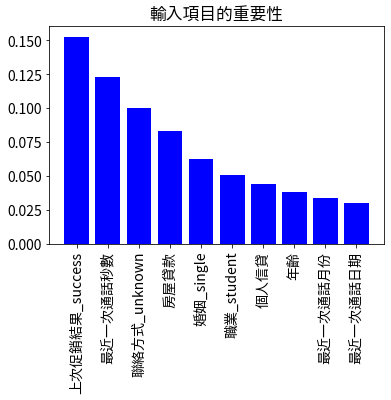

In [ ]:
# 重要性分析

# 取得重要性向量
importances = algorithm.feature_importances_

# 以項目名稱為鍵，生成 Series
w = pd.Series(importances, index=x.columns)

# 按值的大小排序
u = w.sort_values(ascending=False)

# 只提取前 10 個
v = u[:10]

# 繪製重要性的直方圖
plt.title('輸入項目的重要性')
plt.bar(range(len(v)), v, color='b', align='center')
plt.xticks(range(len(v)), v.index, rotation=90)
plt.show()

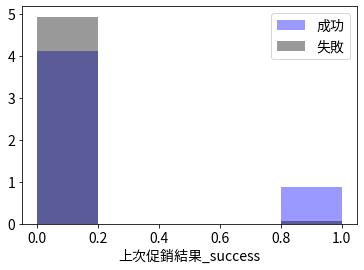

In [ ]:
column = '上次促銷結果_success'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=5, color='k', label='失敗')

plt.legend()
plt.show()

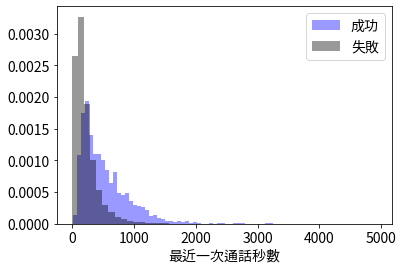

In [ ]:
column = '最近一次通話秒數'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=50, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=50, color='k', label='失敗')

plt.legend()
plt.show()

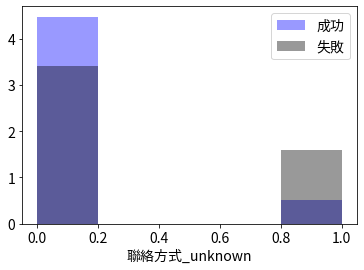

In [ ]:
column = '聯絡方式_unknown'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
            bins=5,color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=5,color='k', label='失敗')

plt.legend()
plt.show()

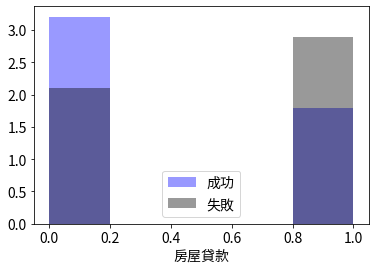

In [ ]:
column = '房屋貸款'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
            bins=5,color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=5,color='k', label='失敗')

plt.legend()
plt.show()

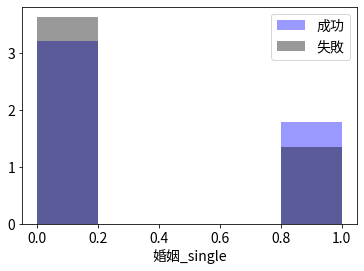

In [ ]:
column = '婚姻_single'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
            bins=5,color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=5,color='k', label='失敗')

plt.legend()
plt.show()